# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [1]:
#!pip install -q torchvision catboost

In [2]:
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

replace to_upload/test_images.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
#!pip install --user upgrade numpy

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import sqrt, ceil
import os
import re
import scipy
import nltk
import time
import random
from pathlib import Path
from nltk.corpus import stopwords
nltk.download('stopwords')
import torchvision.models as models
from nltk.stem import WordNetLemmatizer
from torchvision import transforms
import torch
import torch.nn as nn

import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import  Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from collections import Counter

from PIL import Image

from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
try:
  DATA_PATH = '/content/to_upload'
except:
  DATA_PATH = 'C:\\Data\\to_upload'

In [6]:
try:
  PATH = '/content/to_upload'
except:
  PATH = 'C:\\Data\\to_upload'

In [7]:
WORD_TO_BLOCK = ['teenage', 'baby', 'babies', 'child',
                  'chidren', 'teenager', 'teenages', 'girl',
                  'girls', 'boy', 'boys', 'kid',
                  'kids','infant', 'youngster', 'youngsters']

In [8]:
df_train = pd.read_csv(os.path.join(PATH, 'train_dataset.csv'))
test_queries = pd.read_csv(os.path.join(PATH, 'test_queries.csv'), error_bad_lines=False, sep='|', index_col=0)
train_image_files = [file for file in os.listdir(os.path.join(PATH, 'train_images')) if file.endswith('.jpg')]
train_images_df = pd.DataFrame(train_image_files, columns=['train_file_name'])
test_images_df = pd.read_csv(os.path.join(PATH, 'test_images.csv'))
df_crowd = pd.read_csv(os.path.join(PATH, 'CrowdAnnotations.tsv'), sep='\t', header=None)
df_expert = pd.read_csv(os.path.join(PATH, 'ExpertAnnotations.tsv'), sep='\t', header=None)


<ipython-input-8-301ce4389475>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_queries = pd.read_csv(os.path.join(PATH, 'test_queries.csv'), error_bad_lines=False, sep='|', index_col=0)


In [9]:
def display_dataframe_info(name, df):
    display(name)
    display(df.head(3))
    df.info()
    display('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _')

In [10]:
display_dataframe_info('Training Dataset', df_train)


'Training Dataset'

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [11]:
df_train.describe()

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


In [12]:
display_dataframe_info('Test Queries', test_queries)

'Test Queries'

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [13]:
test_queries.describe()

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


In [14]:
display_dataframe_info('Train Images DataFrame', train_images_df)
print()
train_images_df.describe()

'Train Images DataFrame'

,train_file_name
0,533979933_a95b03323b.jpg
1,2310126952_7dc86d88f6.jpg
2,3334537556_a2cf4e9b9a.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   train_file_name  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

,train_file_name
count,1000
unique,1000
top,533979933_a95b03323b.jpg
freq,1


In [15]:
display_dataframe_info('Test Images DataFrame', test_images_df)
print()
test_images_df.describe()

'Test Images DataFrame'

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

,image
count,100
unique,100
top,3356748019_2251399314.jpg
freq,1


In [16]:
display_dataframe_info('Crowd Annotations DataFrame', df_crowd)
print()
df_crowd.describe()

'Crowd Annotations DataFrame'

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

,2,3,4
count,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155
std,0.207532,0.628898,0.656676
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


In [17]:
display_dataframe_info('Expert Annotations DataFrame', df_expert)
print()
df_expert.describe()

'Expert Annotations DataFrame'

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

,2,3,4
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

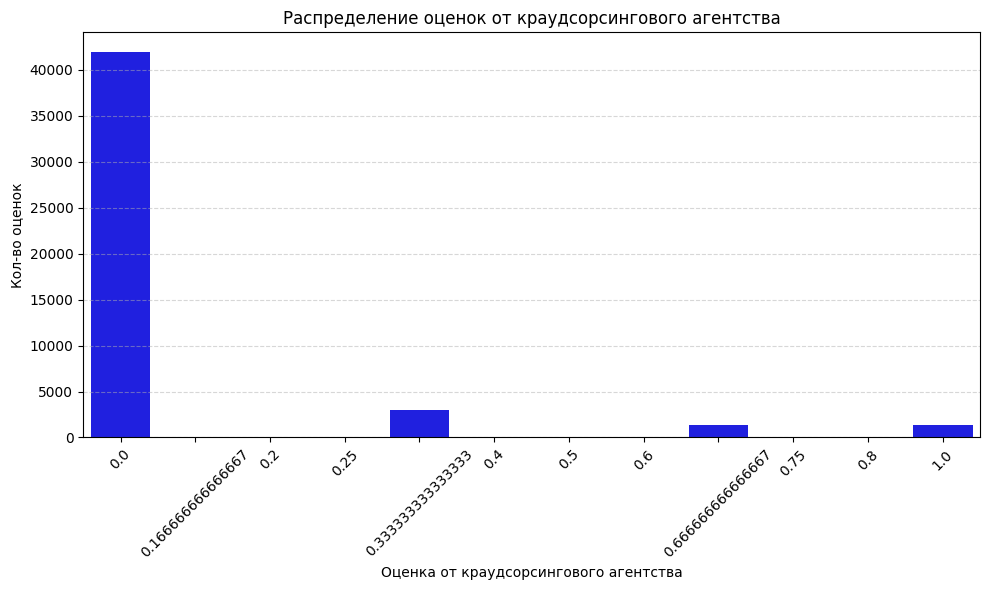

In [18]:
df_crowd_plt = pd.DataFrame(df_crowd[2].value_counts())
df_crowd_plt.columns = ['Кол-во оценок']

plt.figure(figsize=(10, 6))
sns.barplot(x=df_crowd_plt.index, y=df_crowd_plt['Кол-во оценок'], color='blue')
plt.xlabel('Оценка от краудсорсингового агентства')
plt.ylabel('Кол-во оценок')
plt.title('Распределение оценок от краудсорсингового агентства')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [19]:
#Создание списка для итогового хранения оценок

target_expert = []

# Проходим по каждой строке в DataFrame экспертных оценок
for i in range(df_expert.shape[0]):
    labels = df_expert.loc[i, [2, 3, 4]]
    true_label = Counter(labels).most_common(3)

    # Если все три метки уникальны, то добавляем None в список
    if len(true_label) == 3:
        target_expert.append(None)
    else:
        # Иначе добавляем наиболее часто встречающуюся метку
        target_expert.append(true_label[0][0])

# Добавляем столбец с итоговыми оценками к DataFrame и удалим строки с пропущенными значениями
df_expert['target'] = target_expert
df_expert = df_expert.dropna().reset_index(drop=True)

df_expert.head()

,0,1,2,3,4,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0


In [20]:
df_expert['target'] = (df_expert['target'] - 1) / 3
df_expert.tail(3)

,0,1,2,3,4,target
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,0.000000
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,0.000000
5695,997722733_0cb5439472.jpg,486917990_72bd4069af.jpg#2,3,3,3,0.666667


,target
0.000000,3327
0.333333,1566
0.666667,492
1.000000,311


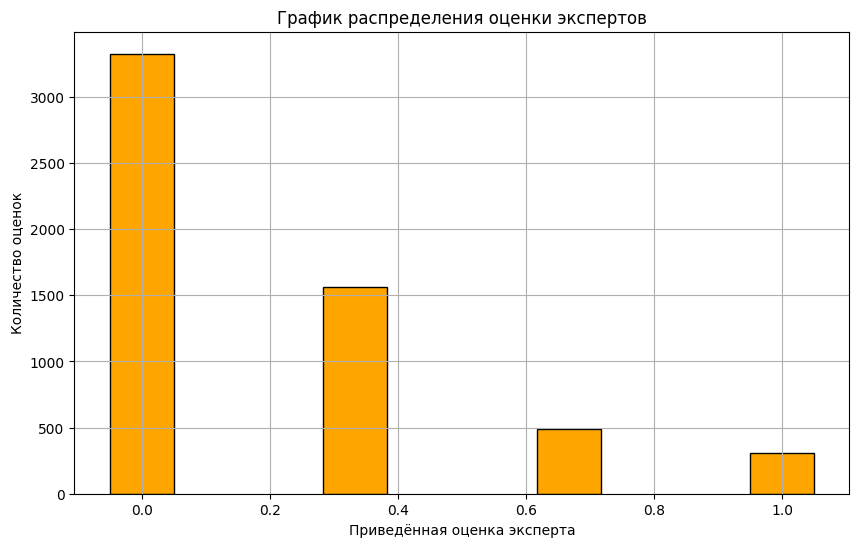

In [21]:
#Распределение оценок экспертов
df_expert_plt = pd.DataFrame(df_expert['target'].value_counts())
df_expert_plt.columns = ['target']
display(df_expert_plt)
fig2, ax2 = plt.subplots()
ax2.bar(df_expert_plt.index, df_expert_plt.target, color = 'orange', edgecolor = 'black', width = 0.1)
fig2.set_figwidth(10)
fig2.set_figheight(6)
ax2.set_xlabel('Приведённая оценка эксперта')
ax2.set_ylabel('Количество оценок')
plt.grid()
plt.title('График распределения оценки экспертов')
plt.show()

In [22]:
#Переименуем столбцы в df_expert и df_crowd
df_expert.columns = ['image', 'query_id', 'exp1', 'exp2', 'exp3', 'target']
df_crowd.columns = ['image', 'query_id', 'rate', 'conf', 'noconf']

#Объединение всех оценок в таблице temp_data
temp_data = df_train.merge(df_expert[['image', 'query_id', 'target']], how='left', on=['image', 'query_id']) \
                    .merge(df_crowd[['image', 'query_id', 'rate']], how='outer', on=['image', 'query_id'])

#Преобразование столбцов target и rate
temp_data['target'] = temp_data['target'].apply(lambda x: x * 0,6)
temp_data['rate'] = temp_data['rate'].apply(lambda x: x * 0.4).fillna(0)

#Вычисляем итоговую оценку в столбце total
temp_data['total'] = temp_data['target'] + temp_data['rate']

#Удаление строк с пропущенными значениями и выбор нужных столбцов
temp_data = temp_data.dropna()
temp_data = temp_data[['image', 'query_id', 'query_text', 'total']]

#Вывод последних строк таблицы temp_data
display(temp_data.tail())

,image,query_id,query_text,total
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,0.133333
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,0.000000
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0.000000
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0.000000
5821,968081289_cdba83ce2e.jpg,2292406847_f366350600.jpg#2,A man rows his boat below .,0.000000


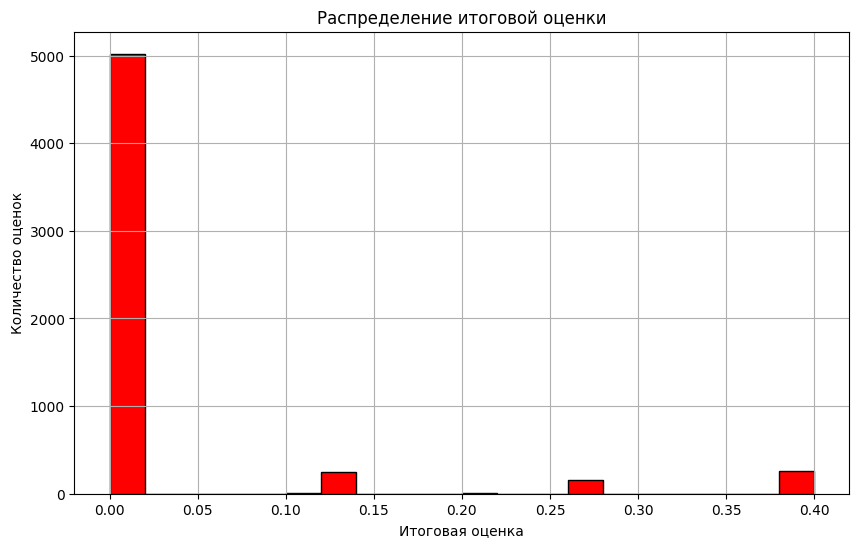

In [23]:
#Создадим таблицу с распределением итоговой оценки
temp_data_plt = pd.DataFrame(temp_data['total'].value_counts())
temp_data_plt.columns = ['total']

#Визуализация графика
fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.hist(temp_data['total'], bins=20, color='red', edgecolor='black')
ax3.set_xlabel('Итоговая оценка')
ax3.set_ylabel('Количество оценок')
ax3.grid(True)
plt.title('Распределение итоговой оценки')
plt.show()

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

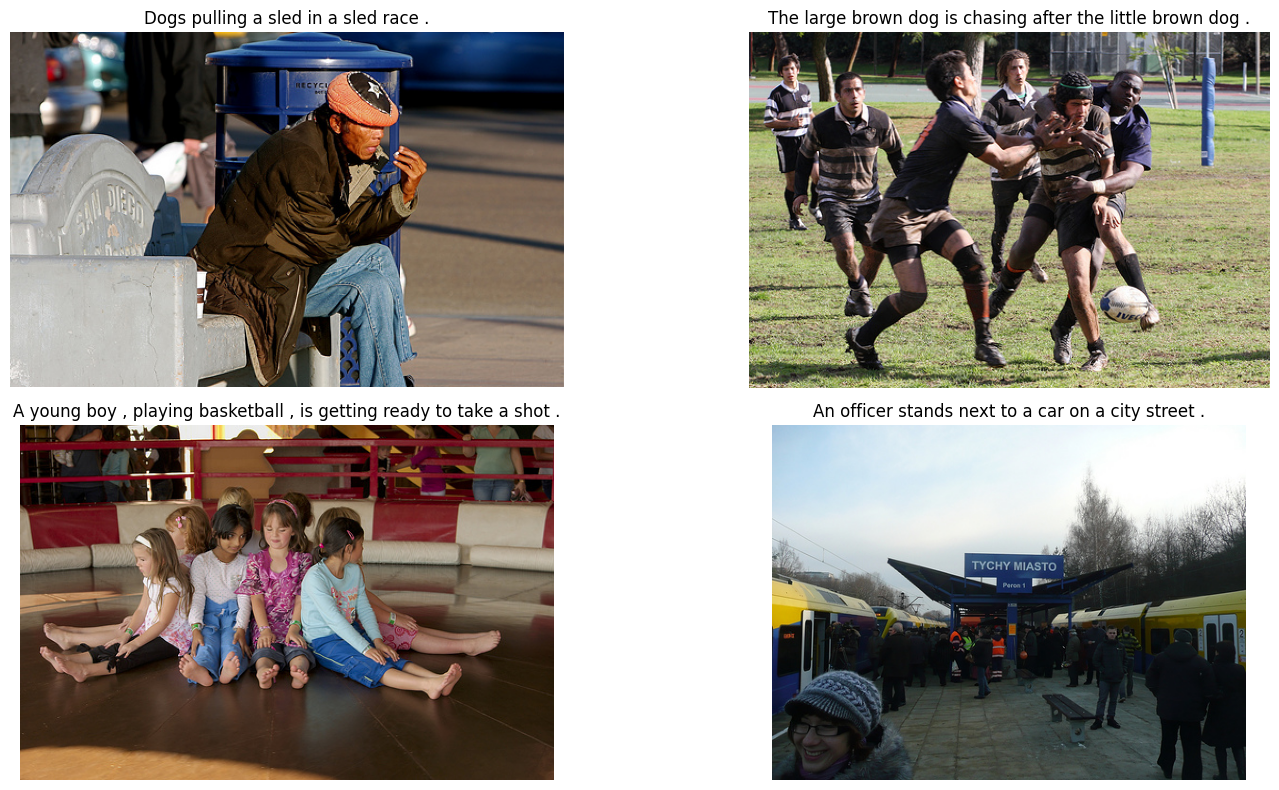

In [24]:
df_train_image_name = df_train['image'].tolist()
df_train_query_text = df_train['query_text'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

for i, ax in enumerate(axes.flatten()):
  random_index = random.randint(0, len(df_train_image_name)-1)
  image_path = os.path.join(DATA_PATH, 'train_images', df_train_image_name[random_index])
  img = Image.open(image_path)
  ax.imshow(img)
  ax.set_title(df_train_query_text[random_index])
  ax.axis('off')

plt.tight_layout()
plt.show()

**Рассмотрим данные на недостатки**

In [25]:
#Создадим новый корпус 'corpus' на основе столбца 'query_text' из 'temp_data'
corpus = pd.DataFrame(temp_data['query_text'])

#Загружаем необходимые ресурсы для лемматезации
nltk.download('wordnet')
nltk.download('punkt')

#Создадим экземпляр класса WordNetLemmatizer для лемматезации слов
lemmatizer = WordNetLemmatizer()

#Определяем функцию 'lemmatize_text' для лемматизации текста
#Принимает текст в виде строки
def lemmatize_text(text):
  #Удаляем символы кроме буквенных символов и приводим текст к нижнему регистру
  text = re.sub('[^a-zA-Z]', ' ', text).lower()

  # Токенизируем текст на слова
  text = nltk.word_tokenize(text)

  #Применяем лемматизацию к каждому слову в тексте
  text = [lemmatizer.lemmatize(word) for word in text]

  #Возвращаем лемматизированный текст в виде списка слов
  return text

#Создадим новый столбец 'lemm_query_text' в корпусе тестов
#Применим функцию  'lemmatize_text' к столбцу 'query_text'
corpus['lemm_query_text'] = corpus['query_text'].apply(lemmatize_text)

#Выводим последние три строки корпуса
display(corpus.tail(3))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,query_text,lemm_query_text
5819,A dog stands on the side of a grassy cliff .,"[a, dog, stand, on, the, side, of, a, grassy, ..."
5820,A blurry photo of two dogs .,"[a, blurry, photo, of, two, dog]"
5821,A man rows his boat below .,"[a, man, row, his, boat, below]"


In [26]:
#Функция 'is_forbidden' проверяет, содержит ли текст запрещённые слова
#Принимаем текст в виде списка слов
def is_forbidden(text):
  #Преобразуем список слов в строку, разделяя слова пробелами
  text = ''.join(text)

  #Проверяем каждое запрещённое слово
  for word in WORD_TO_BLOCK:
    #Если найдётся хотя бы одно запрещённое слово в тексте, возвращаем 1
    if word in text:
      return 1

  #Если запрещённых слов не найдено, возвращаем 0
  return 0

#Создадим новый столбец 'is_forbidden' в корпусе текстов
#Применим функцию 'is_forbidden' к столбцу 'lemm_query_text'
corpus['is_forbidden'] = corpus['lemm_query_text'].apply(is_forbidden)

#Создадим новый корпус, который содержит только тесты с запрещёнными словами
#Затем фильтруем строки, где значение столбца 'is_forbidden' равен 1
#Выбираем только столбцы 'query_text' и 'is_forbidden'
#Удаляем дубликаты строк
forbidden_corpus = corpus[corpus['is_forbidden'] == 1][['query_text', 'is_forbidden']].drop_duplicates()

#Вычисляем количество текстов с запрещёнными словами в корпусе
num_forbidden_texsts = forbidden_corpus.shape[0]

#Выводим результат - количество текстов с запрещёнными словами
num_forbidden_texsts

290

In [27]:
# Лемматизируем текст в столбце 'query_text' с помощью функции lemmatize_text.
temp_data['lemm_query_text'] = temp_data['query_text'].apply(lemmatize_text)

#Объединяем temp_data с forbidden_corpus по столбцу 'query_text' с использованием outer join
#Вышеперечисленное действие позволит объединить данные из обеих таблиц, сохраняя несовпадающие строки в каждой из них.
temp_data = temp_data.merge(forbidden_corpus, left_on='query_text', right_on='query_text', how='outer')

#Отфильтровываем строки, которые содержат запрещенные слова в 'query_text'
#Условие temp_data['is_forbidden'] != 1 вернёт True для всех строк, где 'is_forbidden' не равно 1 (то есть, где нет запрещенных слов).
temp_data = temp_data[temp_data['is_forbidden'] != 1][['image', 'query_id', 'query_text', 'total', 'lemm_query_text','is_forbidden']]

# Выводим последние 3 строки из обновленной таблицы temp_data.
display(temp_data.tail(3))

,image,query_id,query_text,total,lemm_query_text,is_forbidden
5693,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0.0,"[a, dog, stand, on, the, side, of, a, grassy, ...",NaN
5694,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0.0,"[a, blurry, photo, of, two, dog]",NaN
5695,968081289_cdba83ce2e.jpg,2292406847_f366350600.jpg#2,A man rows his boat below .,0.0,"[a, man, row, his, boat, below]",NaN


In [28]:
temp_data.shape

(4172, 6)

In [29]:
#Выводим shape  обновленной таблицы temp_data.
display(temp_data.shape)

#Определяем список плохих комментариев
bad_comments = temp_data['query_id'].apply(lambda x: x[:-2])

#Удаляем пары "изображение/описание" с плохими изображениями из датасета
temp_data = temp_data[~temp_data['image'].isin(bad_comments)]

#Вывод shape обновлённой таблицы temp_data
display(temp_data.shape)

(4172, 6)

(1175, 6)

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [30]:
#Загружаем предобученную модель ResNet-50.
resnet = models.resnet50(pretrained=True)

#Замораживаем параметры модели, чтобы не обучать их заново
for param in resnet.parameters():
    param.requires_grad_(False)

#Выводим список слоёв модели ResNet-50.
display(list(resnet.children()))

#Оставляем предпоследний слой для уменьшения размерности тензора.
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

#Переключам модель в режим оценки (evaluation mode)
resnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [31]:
#Определяяем значения среднего и стандартного отклонения для нормализации изображений
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#Создаём объекты преобразованмй для предоработки изображений
preprocess = transforms.Compose([
    transforms.Resize(256), #масштабируем изображение до 256x256
    transforms.CenterCrop(224), # вырезаем центральную область размером 224x224
    transforms.ToTensor(), #Преобразуем изображение в тензор
    transforms.Normalize(mean, std) #Нормализуем значения тензора по заданному среднему и стандартному отклонению
    ])

In [32]:
#Загрузка изображения
image_path = PATH+'/train_images/1056338697_4f7d7ce270.jpg'
img = Image.open(image_path).convert('RGB')

#Применение преобразований к изображению
image_tensor = preprocess(img)

# Расширение размерности тензора для передачи в сеть
image_tensor = image_tensor.unsqueeze(0)

# Прогон изображения через сеть
output_tensor = resnet(image_tensor).flatten()

#Проверка размерности выходного тензора
output_tensor.size()

torch.Size([2048])

In [33]:
#Установка прогресс-бара
tqdm.pandas()

#Функция векторизации для обучающей выборки
def train_data_image_vect(row):
  img_path = f'{PATH}/train_images/{row["image"]}'
  img = Image.open(img_path).convert('RGB')
  image_tensor = preprocess(img)
  output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
  return output_tensor.numpy()

#Инициализация массива данных для обучающей выборки
train_array = np.array(temp_data.progress_apply(train_data_image_vect, axis=1))

#Вывод массива данных
display(train_array)

  0%|          | 0/1175 [00:00<?, ?it/s]

array([array([0.2884149 , 0.6817508 , 0.08429651, ..., 0.19546743, 0.29693213,
              0.12748897], dtype=float32)                                     ,
       array([0.33847237, 1.3347558 , 0.406118  , ..., 0.23624267, 0.35245454,
              0.5217189 ], dtype=float32)                                     ,
       array([0.19626866, 1.6942418 , 0.53284097, ..., 0.24382438, 1.0784242 ,
              0.67510754], dtype=float32)                                     ,
       ...,
       array([0.0887562 , 1.2452761 , 0.5094019 , ..., 0.58371997, 0.5924664 ,
              0.32028583], dtype=float32)                                     ,
       array([0.0887562 , 1.2452761 , 0.5094019 , ..., 0.58371997, 0.5924664 ,
              0.32028583], dtype=float32)                                     ,
       array([0.12715793, 0.6590405 , 0.46013626, ..., 0.11723436, 0.50723654,
              0.13837881], dtype=float32)                                     ],
      dtype=object)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

In [34]:
# Загрузка списка стоп-слов
nltk.download('stopwords')

# Формирование текстового корпуса для обучающей выборки
corpus_train = temp_data['lemm_query_text'].apply(lambda text: ' '.join(text))

# Создание объекта TfidfVectorizer
stopwords = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stopwords)

# Преобразование текстового корпуса в TF-IDF матрицу
tf_idf_train = vectorizer.fit_transform(corpus_train)

# Вывод размера матрицы лоя обучающей выборки
display('Размер матрицы для обучающей выборки:', tf_idf_train.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'Размер матрицы для обучающей выборки:'

(1175, 877)

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [35]:
data_for_train = np.hstack([np.vstack(train_array), tf_idf_train.toarray()])
display(data_for_train.shape)

(1175, 2925)

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [36]:
# Разделение на обучающую и валидационную выборки с использованием группировки
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_indices, test_indices = next(gss.split(X=data_for_train, y=temp_data['total'], groups=temp_data['image']))

# Создание обучающих и валидационных признаков и целевых переменных
df_data_for_train = pd.DataFrame(data_for_train)  # Создание DataFrame для data_for_train
features_train = df_data_for_train.iloc[train_indices]
features_test = df_data_for_train.iloc[test_indices]
target_train = temp_data['total'].iloc[train_indices].reset_index(drop=True)
target_test = temp_data['total'].iloc[test_indices].reset_index(drop=True)

#Вывод размер выборок
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(810, 2925)

(365, 2925)

(810,)

(365,)

In [37]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(810, 2925) (365, 2925) (810,) (365,)


In [38]:
features_train.head(4)

,0,1,2,3,4,5,6,7,8,9,...,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924
0,0.288415,0.681751,0.084297,0.459975,0.533260,0.440951,0.978222,0.445644,0.619563,0.109135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.338472,1.334756,0.406118,0.183161,1.498986,0.362788,0.276046,0.046909,0.067437,0.247457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.196269,1.694242,0.532841,0.118879,0.272366,0.169882,0.546749,0.689144,0.083941,1.364745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.216565,0.635125,0.288539,0.177796,0.286748,1.163171,0.211024,0.288158,0.637074,0.260627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
target_train.head(4)

0    0.0
1    0.0
2    0.0
3    0.0
Name: total, dtype: float64

In [40]:
#Линейная регрессия
start_time = time.time()

lin_reg = LinearRegression(positive=True)
lin_reg.fit(features_train, target_train)
predictions = lin_reg.predict(features_test)
rmse = np.sqrt(mean_squared_error(target_test, predictions))

end_time = time.time()
execution_time = end_time - start_time

print("RMSE:", rmse)
print('Время выполнения:', execution_time, 'сек.')

RMSE: 1.7579113612792523
Время выполнения: 11.130345106124878 сек.


In [41]:
start_time = time.time()

ridge_reg = Ridge()
ridge_reg.fit(features_train, target_train)
predictions = ridge_reg.predict(features_test)
rmse = np.sqrt(mean_squared_error(target_test, predictions))

end_time = time.time()
execution_time = end_time - start_time

print("RMSE:", rmse)
print('Время выполнения:', execution_time, 'сек.')

RMSE: 0.031548639257601874
Время выполнения: 0.268627405166626 сек.


In [42]:
#Catboost

start_time = time.time()

catboost_reg = CatBoostRegressor()
catboost_reg.fit(features_train, target_train)
predictions = catboost_reg.predict(features_test)
rmse = np.sqrt(mean_squared_error(target_test, predictions))

end_time = time.time()
execution_time = end_time - start_time

print("RMSE:", rmse)
print('Время выполнения:', execution_time, 'сек.')

Learning rate set to 0.039602
0:	learn: 0.0383444	total: 1.08s	remaining: 18m 4s
1:	learn: 0.0381105	total: 1.54s	remaining: 12m 49s
2:	learn: 0.0378158	total: 1.99s	remaining: 11m
3:	learn: 0.0375807	total: 2.43s	remaining: 10m 5s
4:	learn: 0.0373501	total: 2.87s	remaining: 9m 30s
5:	learn: 0.0370234	total: 3.32s	remaining: 9m 9s
6:	learn: 0.0368272	total: 3.76s	remaining: 8m 53s
7:	learn: 0.0365044	total: 4.21s	remaining: 8m 42s
8:	learn: 0.0361678	total: 4.66s	remaining: 8m 33s
9:	learn: 0.0359734	total: 5.4s	remaining: 8m 54s
10:	learn: 0.0356401	total: 6.21s	remaining: 9m 17s
11:	learn: 0.0354468	total: 7.01s	remaining: 9m 37s
12:	learn: 0.0351176	total: 7.78s	remaining: 9m 50s
13:	learn: 0.0348411	total: 8.21s	remaining: 9m 38s
14:	learn: 0.0346088	total: 8.65s	remaining: 9m 28s
15:	learn: 0.0343440	total: 9.09s	remaining: 9m 19s
16:	learn: 0.0340727	total: 9.56s	remaining: 9m 12s
17:	learn: 0.0337871	total: 9.98s	remaining: 9m 4s
18:	learn: 0.0334977	total: 10.4s	remaining: 8m 5

In [43]:
#Модель случайного леса

start_time = time.time()

rf_reg = RandomForestRegressor()
rf_reg.fit(features_train, target_train)
predictions = rf_reg.predict(features_test)
rmse = np.sqrt(mean_squared_error(target_test, predictions))

end_time = time.time()
execution_time = end_time - start_time

print("RMSE:", rmse)
print('Время выполнения:', execution_time, 'сек.')

RMSE: 0.028500591464929934
Время выполнения: 85.20720958709717 сек.


In [44]:
best_score=0.02869958818960062

In [45]:
np.random.seed(42)
torch.manual_seed(42)

n_in_neurons = int(features_train.shape[1])
n_hidden_neurons = [1024, 512, 256, 2]
n_out_neurons = 1

display(f'Количество нейронов на входном слое: {n_in_neurons}')
for i, n_neurons in enumerate(n_hidden_neurons):
    display(f'Количество нейронов на скрытом слое {i+1}: {n_neurons}')
display(f'Количество нейронов на выходе: {n_out_neurons}')

class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons, n_out_neurons, activations):
        super(Model, self).__init__()

        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList(activations)

        #Вход
        self.layers.append(nn.Linear(n_in_neurons, n_hidden_neurons[0]))

        #Внутри
        for i in range(1, len(n_hidden_neurons)):
            self.layers.append(nn.Linear(n_hidden_neurons[i-1], n_hidden_neurons[i]))

        #Выход
        self.layers.append(nn.Linear(n_hidden_neurons[-1], n_out_neurons))

        for layer in self.layers:
            nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.activations[i](x)
        x = self.layers[-1](x)
        x = nn.Sigmoid()(x)
        return x


activations = [nn.ReLU() for _ in range(len(n_hidden_neurons) - 1)]
activations.append(nn.PReLU())


model = Model(n_in_neurons, n_hidden_neurons, n_out_neurons, activations)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss = nn.MSELoss()

num_epochs = 11
batch_size = 50
num_batches = ceil(len(features_train) / batch_size)
best_rmse = best_score

for epoch in tqdm(range(num_epochs)):
    order = np.random.permutation(len(features_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = torch.tensor(features_train.iloc[batch_indexes].values, dtype=torch.float32)
        y_batch = torch.tensor(target_train.iloc[batch_indexes].values, dtype=torch.float32)
        preds = model(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        model.eval()
        test_preds = model(torch.tensor(features_test.values, dtype=torch.float32))
        rmse = sqrt(mean_squared_error(target_test.values, test_preds.detach().numpy()))
        display(f'epoch: {epoch}, rmse: {rmse}, best_rmse: {best_rmse}')
        if rmse < best_rmse:
          best_rmse = rmse

display('Лучшее значение RMSE:', round(best_rmse, 5))

'Количество нейронов на входном слое: 2925'

'Количество нейронов на скрытом слое 1: 1024'

'Количество нейронов на скрытом слое 2: 512'

'Количество нейронов на скрытом слое 3: 256'

'Количество нейронов на скрытом слое 4: 2'

'Количество нейронов на выходе: 1'

  0%|          | 0/11 [00:00<?, ?it/s]

'epoch: 0, rmse: 0.1772731782650891, best_rmse: 0.02869958818960062'

'epoch: 10, rmse: 0.03750255667254535, best_rmse: 0.02869958818960062'

'Лучшее значение RMSE:'

0.0287

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [46]:
%%time
tqdm.pandas()
#Функция вектора для тестовой выборки
def test_data_img_vect(row):
    img = Image.open(path_test+row['image']).convert('RGB')
    image_tensor = preprocess(img)
    output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
    output_tensor.size()
    return output_tensor.numpy()
path_test = PATH+'/test_images/'

CPU times: user 987 µs, sys: 0 ns, total: 987 µs
Wall time: 1.19 ms


In [47]:
test_vect_img = torch.tensor(test_images_df.progress_apply(test_data_img_vect, axis=1))

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-47-d5cf63fe402f>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  test_vect_img = torch.tensor(test_images_df.progress_apply(test_data_img_vect, axis=1))


In [48]:
display(test_vect_img.shape)

torch.Size([100, 2048])

In [49]:
def get_top_simular_images(text, test_vect_img, tf_idf_train, test_images_df, model_):
    if [i for i in lemmatize_text(text) if i in WORD_TO_BLOCK]:
      print('')
      print('-' * 20, text, '-' * 20)
      print('')
      print('Это изображение недоступно в вашей стране в соответствии с местным законодательством')
      print('')
      return None

    text_vect = vectorizer.transform([text])
    X = np.concatenate((test_vect_img, np.resize(text_vect.toarray(), (test_vect_img.shape[0], tf_idf_train.shape[1]))), axis=1)
    X = np.float32(X)
    X = torch.from_numpy(X)

    with torch.no_grad():
      predictions = model_.predict(X.numpy())

    df = pd.concat((test_images_df, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1)
    top_simular_images = df.sort_values(by='pred', ascending=False).head(5)
    return top_simular_images

In [50]:
def prob_img(text, test_vect_img, tf_idf_train, test_images_df, model_):
  top_simular_images = get_top_simular_images(text, test_vect_img, tf_idf_train, test_images_df, model_)

  if top_simular_images is None:
    return

  print('')
  print('-' * 20, text, '-' * 20)
  print('')

  fig = plt.figure(figsize=(15, 5))
  plt.rcParams['axes.edgecolor'] = 'black'
  plt.rcParams['axes.linewidth'] = 0

  for i, (index, row) in enumerate(top_simular_images.iterrows()):
    fig.add_subplot(1, 6, i+1, title=round(row['pred'], 2))
    image = Image.open(f'{path_test}')
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

  if text in list(test_queries['query_text']):
    plt.rcParams['axes.edgecolor'] = 'green'
    plt.rcParams['axes.linewidth'] = 5
    fig.add_subplot(1, 6, 6)
    img_temp = test_queries.loc[test_queries[test_queries['query_text'] == text].index[0]]['image']
    image = Image.open('f{path_test}{img_temp}')
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

  plt.show()


In [51]:
#Получение выборки из 15 описаний
random_test_queries = test_queries.sample(15, random_state=42)
text_test = list(random_test_queries['query_text'])
display(text_test)

['A group of girls who are gothically dressed standing together',
 'A woman and girl riding downhill on a sled with a dog running alongside them',
 'The dog is running .',
 'A group of people are ice skating in a big city .',
 'Little kid in blue coat and hat riding a tricycle .',
 'Two black dogs fighting over an orange toy .',
 'A dog jumping for a tennis ball near an ocean',
 'Boy flying a distant kite .',
 'kids play ultimate Frisbee .',
 'A girl in a purple shirt feeding ducks',
 'There is a little blond hair girl with a green sweatshirt and a red shirt playing on a playground .',
 'The brown German shepherd dog is playing with a stick .',
 'a little girl blows out her candles .',
 'The little boy is smiling as he crosses a rope on an assault course .',
 'A little white dog in running on the sidewalk .']


-------------------- A group of girls who are gothically dressed standing together --------------------

Это изображение недоступно в вашей стране в соответствии с местным законодательством


-------------------- A woman and girl riding downhill on a sled with a dog running alongside them --------------------

Это изображение недоступно в вашей стране в соответствии с местным законодательством


-------------------- The dog is running . --------------------



IsADirectoryError: ignored

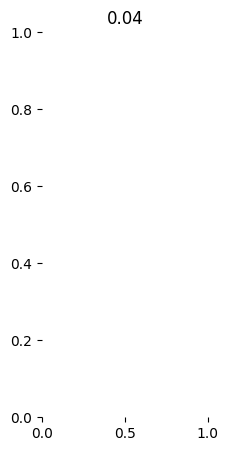

In [52]:
#Получение результата работы функции
for text in text_test:
    prob_img(text, test_vect_img, tf_idf_train, test_images_df, catboost_reg)

**Выводы**

**Линейная регрессия:** RMSE: 1.7579113612792523 Время выполнения: 11.130345106124878 сек.

**Ridge регрессия:** RMSE: 0.031548639257601874
Время выполнения: 0.268627405166626 сек.

**Catboost: RMSE:** 0.027997955724111668
Время выполнения: 496.1488981246948 сек.

**Модель случайного леса:** RMSE: 0.028500591464929934
Время выполнения: 85.20720958709717 сек.

**Нейронная сеть:** RMSE: 0.0287

Catboost оказался лучшей моделью с наименьшим значением RMSE.

Модель случайного лесе довольна блиска по показателям к наилучшей модели Catboost. Также хорошо себя показала нейронная сеть.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска